In [2]:
# Cell 1: Imports & Setup
from typing import List, Dict, Any, Literal
from datetime import datetime
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver

# For prompt building
from langchain_core.prompts import ChatPromptTemplate

# ✅ Assume llm is available as in your current environment
# e.g., from startup_wcp import llm
from startup_wcp import llm

print("✅ Environment ready for LangGraph Sia CreditWise")


/home/ubuntu/sarvm-app/LLM_NLU/app/startup_wcp.py:25: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=MODEL_NAME)
/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ WCP Resources loaded: FAISS + Embeddings + Groq LLM
✅ Environment ready for LangGraph Sia CreditWise


In [3]:
# Cell 2: Define State

class SiaCallState(MessagesState):
    """State for the Sia CreditWise multi-agent system."""
    next_agent: str = ""
    customer_data: Dict[str, Any] = {}
    report: Dict[str, Any] = {
        "Disposition": "Not Available",
        "Call Back": "-",
        "RPC": "No"
    }
    chat_history: List[Dict[str, str]] = []
    task_complete: bool = False
    first_turn: bool = True


In [4]:
# Cell 3: Greeting Agent

def greeting_agent(state: SiaCallState) -> Dict:
    customer_data = state.get("customer_data", {})
    customer_name = customer_data.get("Customer_Name", "Customer")
    product_type = customer_data.get("Product_Type", "Loan")

    reply = (
        f"Hello! I’m Sia from CreditWise Capital, "
        f"calling regarding your {product_type} loan. "
        f"Am I speaking with {customer_name}?"
    )

    return {
        "messages": [AIMessage(content=reply)],
        "next_agent": "supervisor_agent",
        "chat_history": state.get("chat_history", []) + [{"user": "", "bot": reply}],
        "task_complete": False,
        "first_turn": False
    }


In [5]:
# Cell 4: Supervisor Agent + Router

def supervisor_agent(state: SiaCallState) -> Dict:
    """Routes user input to the right agent based on conversation context."""
    
    messages = state.get("messages", [])
    chat_history = state.get("chat_history", [])
    user_msg = messages[-1].content if messages else ""
    customer_name = state.get("customer_data", {}).get("Customer_Name", "Customer")

    # Basic routing rules (can be expanded later with LLM)
    next_agent = "faq_agent"  # default fallback
    
    msg_lower = user_msg.lower()

    if any(x in msg_lower for x in ["yes", "haan", "i am", "speaking"]):
        next_agent = "happy_agent"
    elif any(x in msg_lower for x in ["wrong", "don't know", "galat", "glt"]):
        next_agent = "wrongnumber_agent"
    elif any(x in msg_lower for x in ["brother", "sister", "friend", "father", "mother"]):
        next_agent = "thirdparty_agent"
    elif any(x in msg_lower for x in ["busy", "call later", "later", "baad me"]):
        next_agent = "callback_agent"
    elif any(x in msg_lower for x in ["dispute", "problem", "issue", "galti"]):
        next_agent = "dispute_agent"
    elif any(x in msg_lower for x in ["bye", "thank", "stop", "done"]):
        next_agent = "end_agent"

    print(f"🧠 Supervisor decided next agent: {next_agent}")

    return {
        "messages": [],  # Supervisor does not speak
        "next_agent": next_agent,
        "chat_history": chat_history + [{"user": user_msg, "bot": ""}],
    }


def router(state: SiaCallState) -> str:
    # ✅ End if task is complete
    if state.get("task_complete", False):
        return END

    next_agent = state.get("next_agent", "supervisor_agent")

    # ✅ End if agent explicitly returned "end"
    if next_agent in ["end", "end_agent"]:
        return END

    valid_agents = [
        "supervisor_agent", "greeting_agent", "happy_agent",
        "callback_agent", "wrongnumber_agent", "thirdparty_agent",
        "faq_agent", "dispute_agent"
    ]

    return next_agent if next_agent in valid_agents else "supervisor_agent"



In [6]:
# Cell 5: Core Conversation Agents

def happy_agent(state: SiaCallState) -> Dict:
    """User confirmed identity – share loan + EMI info"""
    customer_data = state.get("customer_data", {})
    product_type = customer_data.get("Product_Type", "Loan")
    loan_amount = customer_data.get("Loan_Amount", "XX")
    due_date = customer_data.get("Due_Date", "XX/XX/XXXX")
    emi_amount = customer_data.get("EMI_Amount", "XX")

    reply = (
        f"Thank you for confirming your identity. "
        f"Your {product_type} loan of ₹{loan_amount} has an EMI of ₹{emi_amount}, "
        f"due on {due_date}. Please ensure sufficient balance before the due date."
    )

    return {
        "messages": [AIMessage(content=reply)],
        "next_agent": "supervisor_agent",
        "chat_history": state["chat_history"] + [{"user": state["messages"][-1].content, "bot": reply}],
        "report": {**state.get("report", {}), "Disposition": "Information Conveyed", "RPC": "Yes"}
    }


def wrongnumber_agent(state: SiaCallState) -> Dict:
    """Handle wrong number"""
    reply = "I’m sorry for the disturbance. Have a nice day!"
    
    return {
        "messages": [AIMessage(content=reply)],
        "next_agent": "end_agent",
        "chat_history": state["chat_history"] + [{"user": state["messages"][-1].content, "bot": reply}],
        "report": {**state.get("report", {}), "Disposition": "Wrong Number"},
        "task_complete": True
    }


def thirdparty_agent(state: SiaCallState) -> Dict:
    """Handle third-party pickup"""
    reply = "Could you please let me know when the customer will be available for the call?"
    
    return {
        "messages": [AIMessage(content=reply)],
        "next_agent": "supervisor_agent",
        "chat_history": state["chat_history"] + [{"user": state["messages"][-1].content, "bot": reply}],
        "report": {**state.get("report", {}), "Disposition": "Third Party Contact"}
    }


In [9]:
# Cell 6: Callback, FAQ, Dispute, End Agents
from prompt_wcp import (
    build_supervisor_prompt,
    build_greeting_prompt,
    build_callback_prompt,
    build_thirdparty_prompt,
    build_happy_prompt,
    build_wrongnumber_prompt,
    build_faq_prompt,
    build_dispute_prompt,
    build_end_prompt,
)
from startup_wcp import llm, docsearch

def callback_agent(state: SiaCallState) -> Dict:
    """Handle 'call later' or busy user response"""
    reply = "Sure, I’ll call you back later at a convenient time. Have a great day!"
    return {
        "messages": [AIMessage(content=reply)],
        "next_agent": "end_agent",
        "chat_history": state["chat_history"] + [{"user": state["messages"][-1].content, "bot": reply}],
        "report": {**state.get("report", {}), "Disposition": "Callback Requested"},
        "task_complete": True
    }

def faq_agent(state: SiaCallState) -> Dict:
    """Handles loan/EMI-related queries using FAISS (RAG)"""
    
    messages = state.get("messages", [])
    user_msg = messages[-1].content if messages else "..."
    chat_history = state.get("chat_history", [])
    customer_data = state.get("customer_data", {})
    language = state.get("language", "English")

    # Search FAISS for relevant context
    docs = docsearch.similarity_search(user_msg, k=2)
    context = " ".join([doc.page_content for doc in docs]) if docs else "(No context found)"

    prompt = build_faq_prompt(user_msg, context, customer_data, chat_history, language)
    response = llm.invoke([HumanMessage(content=prompt)])
    reply = response.content.strip()

    # ✅ Mark as task complete for now (avoid infinite loop)
    return {
        "messages": [AIMessage(content=reply)],
        "next_agent": "end_agent",  # ✅ End after answering FAQ
        "chat_history": chat_history + [{"user": user_msg, "bot": reply}],
        "report": state.get("report", {}),
        "task_complete": True       # ✅ Critical to break the loop
    }


def dispute_agent(state: SiaCallState) -> Dict:
    """Handles disputes politely and ends call"""
    user_msg = state["messages"][-1].content
    reply = (
        f"I understand your concern: '{user_msg}'. "
        "We’ll escalate this to our team for resolution. Thank you for your patience."
    )
    return {
        "messages": [AIMessage(content=reply)],
        "next_agent": "end_agent",
        "chat_history": state["chat_history"] + [{"user": user_msg, "bot": reply}],
        "report": {**state.get("report", {}), "Disposition": "Dispute/Human Intervention Required"},
        "task_complete": True
    }

def end_agent(state: SiaCallState) -> Dict:
    """Politely closes the call"""
    reply = "Thank you for your time. Have a wonderful day ahead!"
    return {
        "messages": [AIMessage(content=reply)],
        "next_agent": "end",
        "chat_history": state["chat_history"] + [{"user": "", "bot": reply}],
        "report": {**state.get("report", {}), "Disposition": "Call Closed"},
        "task_complete": True
    }


In [10]:
# Cell 7: Build LangGraph workflow

memory = MemorySaver()
workflow = StateGraph(SiaCallState)

# Add all agents
workflow.add_node("supervisor_agent", supervisor_agent)
workflow.add_node("happy_agent", happy_agent)
workflow.add_node("wrongnumber_agent", wrongnumber_agent)
workflow.add_node("thirdparty_agent", thirdparty_agent)
workflow.add_node("callback_agent", callback_agent)
workflow.add_node("faq_agent", faq_agent)
workflow.add_node("dispute_agent", dispute_agent)
workflow.add_node("end_agent", end_agent)

# Set entry point to supervisor
workflow.set_entry_point("supervisor_agent")

# Add routing for all nodes
for node in [
    "supervisor_agent",
    "happy_agent",
    "wrongnumber_agent",
    "thirdparty_agent",
    "callback_agent",
    "faq_agent",
    "dispute_agent",
    "end_agent"
]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "supervisor_agent": "supervisor_agent",
            "happy_agent": "happy_agent",
            "wrongnumber_agent": "wrongnumber_agent",
            "thirdparty_agent": "thirdparty_agent",
            "callback_agent": "callback_agent",
            "faq_agent": "faq_agent",
            "dispute_agent": "dispute_agent",
            "end_agent": "end_agent",
            END: END
        }
    )

graph = workflow.compile(checkpointer=memory)
print("✅ LangGraph workflow compiled successfully")


✅ LangGraph workflow compiled successfully


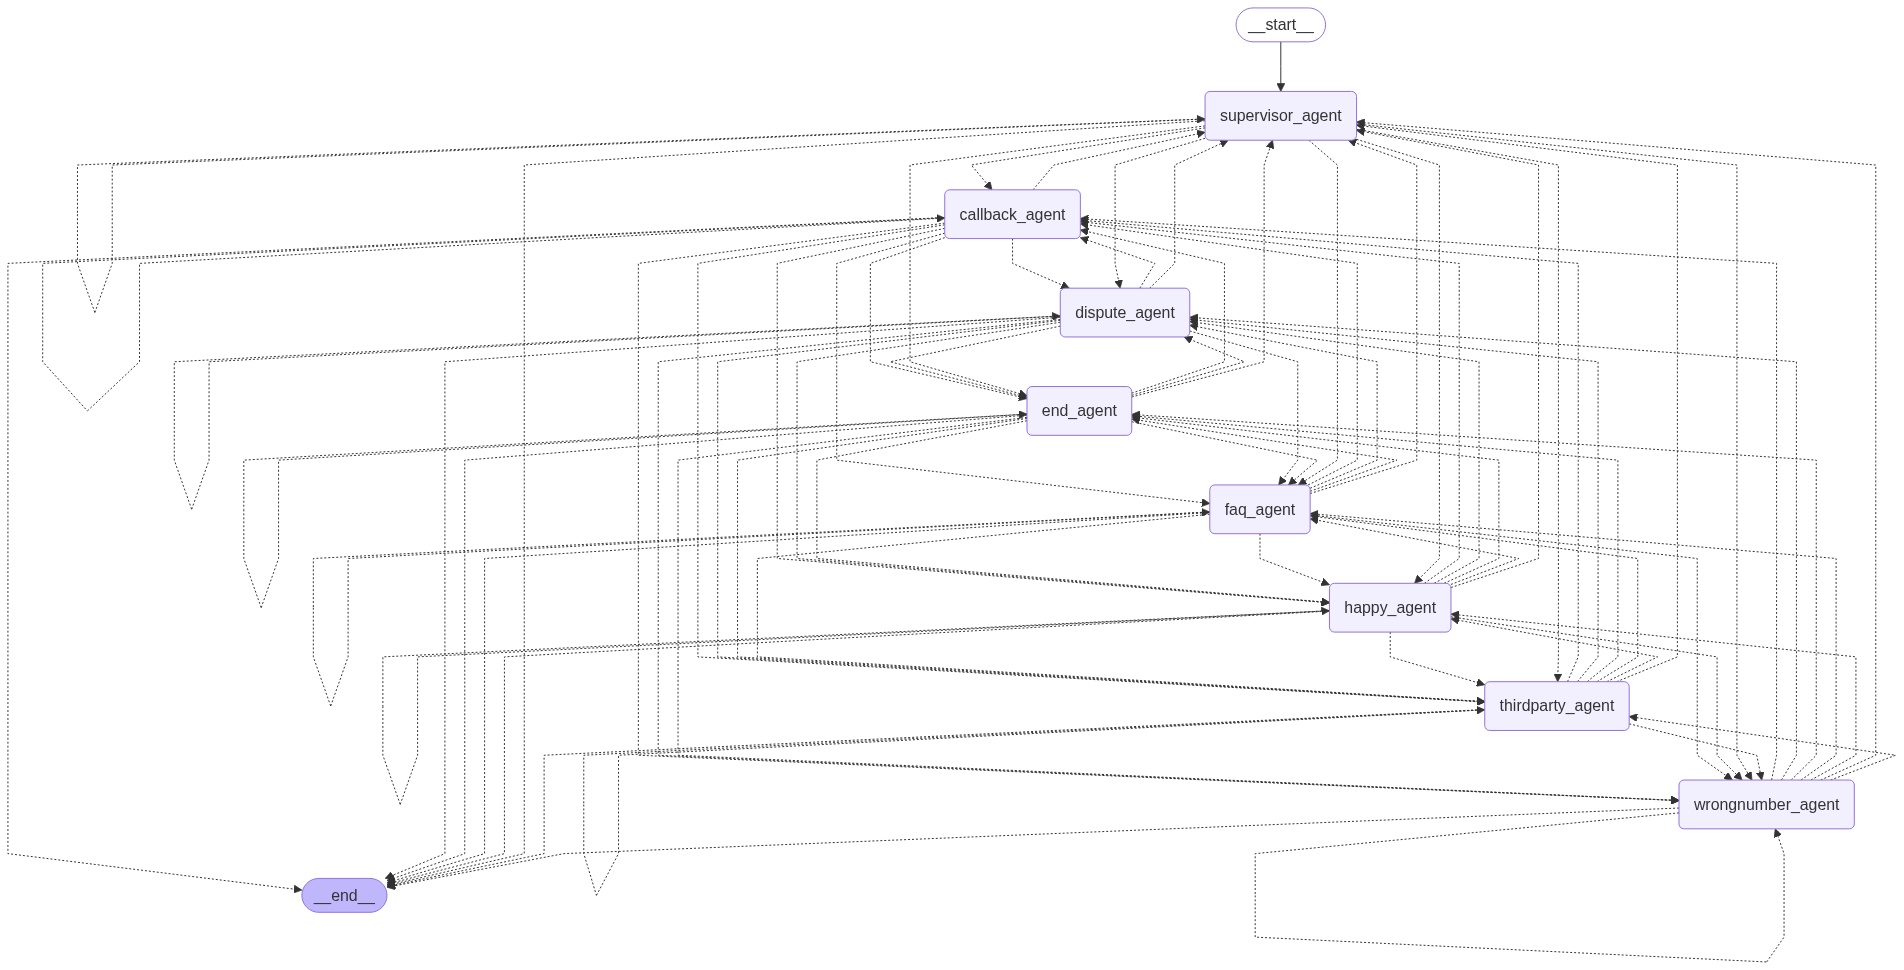

In [11]:
# Cell 8: Visualize the graph
graph


In [20]:
    sample_state = {
        "messages": [HumanMessage(content="Who am I speaking with?")],
        "customer_data": {"Customer_Name": "Sidharth", "Product_Type": "Two Wheeler"},
        "chat_history": [],
        "report": {},
        "next_agent": "supervisor_agent",
        "task_complete": False
    }

    response = graph.invoke(
        sample_state,
        config={
            "configurable": {"thread_id": "test_session_1"},
            "recursion_limit": 50  # ✅ Increased to prevent early error
        }
    )

    print("Final Response:\n", response["messages"][-1].content)
    print("\nReport:", response.get("report", {}))


🧠 Supervisor decided next agent: happy_agent
🧠 Supervisor decided next agent: end_agent
Final Response:
 Thank you for confirming your identity. Your Two Wheeler loan of ₹XX has an EMI of ₹XX, due on XX/XX/XXXX. Please ensure sufficient balance before the due date.

Report: {'Disposition': 'Information Conveyed', 'RPC': 'Yes'}
